In [ ]:
!pip install transformers

In [ ]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: not installed



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
#pd.set_option('max_columns', None)

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
import pandas as pd
import numpy as np
import csv
import re
import pickle
import tqdm
from collections import Counter
import random
import os

import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = torch.load('/content/drive/MyDrive/best_model_state.bin')


In [ ]:
train = pickle.load(open('/content/drive/MyDrive/train_new.pkl', 'rb'))
train_text = train['posts_text']
train_label = train['annotations']
    #eval = test = train
    # test set
test = pickle.load(open('/content/drive/MyDrive/test_new.pkl', 'rb'))
test_text = test['posts_text']
test_label = test['annotations']

In [ ]:
def process_data(poster, label):
    label_lookup = {'E': 1, 'I': 0, 'S': 1, 'N':0, 'T': 1, 'F': 0, 'J': 1, 'P':0}
    persona_lookup = {}
    poster_data = [{'posts': t, 'label0': label_lookup[list(label[i])[0]],
                    'label1': label_lookup[list(label[i])[1]],'label2': label_lookup[list(label[i])[2]],
                    'label3': label_lookup[list(label[i])[3]]} for i,t in enumerate(poster)]
    I,E,S,N,T,F,P,J=0,0,0,0,0,0,0,0
    for t in label:
        if 'I' in t:
            I+=1
        if 'E' in t:
            E += 1
        if 'S' in t:
            S+=1
        if 'N' in t:
            N+=1
        if 'T' in t:
            T+=1
        if 'F' in t:
            F+=1
        if 'P' in t:
            P+=1
        if 'J' in t:
            J+=1
        if t not in persona_lookup:
            persona_lookup[t] = 1
        else:
            persona_lookup[t] += 1
    return poster_data
    # process
deal_train_data = process_data(train_text, train_label)
deal_test_data = process_data(test_text, test_label)

In [ ]:
#introvert data
introvert_data =[]
extrovert_data =[]
sensor_data = []
intuition_data = []
feeling_data = []
thinking_data = []
judging_data = []
percieving_data = []
for data in deal_test_data:
  if data['label0']==0:
    introvert_data.append(data['posts'])
  if data['label0']==1:
    extrovert_data.append(data['posts'])
  if data['label1']==0:
    intuition_data.append(data['posts'])
  if data['label1']==1:
    sensor_data.append(data['posts'])
  if data['label2']==0:
    feeling_data.append(data['posts'])
  if data['label2']==1:
    thinking_data.append(data['posts'])
  if data['label3']==0:
    percieving_data.append(data['posts'])
  if data['label3']==1:
    judging_data.append(data['posts'])




In [ ]:
test_df = pd.DataFrame(deal_test_data)
train_df = pd.DataFrame(deal_train_data)

In [ ]:
# Hyperparameters
num_labels = 4
num_classes_per_label = 2
batch_size = 8
max_length = 512
learning_rate = 2e-5
epochs = 5
model = PersonalityClassifier(num_labels)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state.bin'))
model.eval()

<All keys matched successfully>

PersonalityClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model = model.to(device)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
class PersonalityClassifier(nn.Module):

    def __init__(self, n_labels):
        super(PersonalityClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_labels*2)
    def forward(self, input_ids, attention_mask):
      _, pooled_output = self.bert(input_ids = input_ids, attention_mask=attention_mask)
      #pooled_output = outputs['pooler_output']
      pooled_output = self.drop(pooled_output)
      logits = self.out(pooled_output)
      return logits

In [ ]:
!pip install torch transformers eli5 lime
import torch
from transformers import BertTokenizer, BertModel
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LinearRegression
import eli5

In [ ]:
# def predict_with_bert_linear(text):
#     with torch.no_grad():
#       texts =' '.join(text)
#       inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
#       input_ids = inputs['input_ids'].to(device)
#       attention_mask = inputs['attention_mask'].to(device)
#       logits = model(input_ids, attention_mask)
#       logits = logits.view(-1, num_labels, num_classes_per_label)
#       _, predicted = torch.max(logits, dim=2)
#     return predicted.detach().cpu.numpy()

In [ ]:
'''Take a list of strings as input and output a
 2d array of prediction probabilities.
'''

sample_text = ["I am going to believe in my strengths.Instead of being bogged down by my weaknesses."]
def predict_with_bert_linear(sample_text):
  predictions=[]
  examples = []
  for text in sample_text:
    inputs = tokenizer.encode_plus(text,add_special_tokens=True,
          max_length= 160,
          truncation=True,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
      logits = model(input_ids=input_ids, attention_mask=attention_mask)
      #print(logits.data)
    logits = logits.view(-1, num_labels, num_classes_per_label)
    #print(logits)
    predicted = torch.softmax(logits, dim=2)
    # Introvert class
    predictions.append(predicted.cpu().detach().numpy()[0][0])
    # Extrovert class
    #predictions.append(np.fliplr(predicted.cpu().detach().numpy())[0][0])
    # Intuition class
    #predictions.append(predicted.cpu().detach().numpy()[0][1])
    # Sensing class
    #predictions.append(np.fliplr(predicted.cpu().detach().numpy())[0][1])
    # Feeling class
    #predictions.append(predicted.cpu().detach().numpy()[0][2])
    # Thinking class
    #predictions.append(np.fliplr(predicted.cpu().detach().numpy())[0][2])
    #Judging class
    #predictions.append(predicted.cpu().detach().numpy()[0][3])
    # percieving class
    predictions.append(np.fliplr(predicted.cpu().detach().numpy())[0][3])
  predictions = np.stack(predictions, axis=0)
  print(predictions)
  return predictions

In [ ]:
sample_text ="Still the same in France and the UK Beach House is amazing! Id say they were as bad as each other, its just greed on two different scales. Anthropology! Its really fascinating, and can help understand people and culture a lot better. Its a huge domain, with academic books, more casual books, articles as well as films. It covers literally everything people do in groups, in all kinds of communities and cultures of different scales. Oh thats funny! I didnt really notice that at all. Of course, I only kno"
sample_text2="The rotors and the discs are the same thing, and yeah just get pictures of the calipers and the discs/rotors through the wheels, just make sure it's lit up nicely. They are boring and slow, literally the opposite of what I want in a bike, so therefore it is horrible. I had one as a courtesy bike, they are crap, If you disagree then fine but I suggest you try out another 125. Second hand DRZ please. From the spec sheet Top speed: How brave are you? Neither are important. By the time we have actually left, "
sample_text3="Were you tripping with other people or were you doing it alone? But all that is still part of your subjective reality, those are all just concepts. Even in quantum mechanics, our theories don't really tell us what's true and what's real. They just explain the behavior of things. They're symbols for reality. They're not really real. I don't know ... but as a kid I always had to be keenly aware of my mother's emotional state to avoid her blowing up on me. Might have contributed to me becoming and TYPE_MENTION"
sample_text4 = "what problem are you trying to solve here, exactly? I have a feeling there's a more suitable approach Would be nice if the post included a benchmark. Saying do this and not that without any empirical motivation has a way of going right through people's ears. which honestly only further underlines his point don't leave me hanging! I think this has potential, so I just thought I'd be honest. You were a pretty good at conveying the concepts for the most part! famous last words or any other place outside of t"
sample_text5 = "I know right? I can't believe I found this gem.  They seemed ahead of their time with this one especially, like it was predicting the grunge era to come in a few years. Just in time for Dr. Strange! I stopped it when he said Stranger Things was good, but not *great*.  Umm, get the fuck out of here with that kind of opinion. [For those curious, here's a man being bit by several bullet ants.]( Interesting...makes sense to be addicted to an opiate.  Despite what the majority of people think about them (that"
sample_text6 = "I mean yes, I'm csci too. :Pedit: I do vaguely remember buying books my first semester...edit2: heey you play KSP, cool But I just wanna play rocket league... :/ Weird, I've been there. What kind of camera/lense? yeah i have that i5 processor and p3d v3 works great with it or the bit where the username is DutchGameStudent This. A beer or two or some wine makes housecleaning suddenly pretty enjoyable. Thanks! Chromebooks actually usually work, you just have to set it up manually. The security type is WPA2,"
sample_text7 ="Interesting. I am an attractive woman in tech sales and to be honest I always felt it was a distraction to my actual competency. Bitch please. I will cut someone who accosts me on my morning jog any day of the week.  Not that I'm on par with some Syrian rebel squads or anything.Let me guess, you're also an All Lives Matter kind of fuck. Because he had support of the people.  HAHAHA I love it, Satan. Hello, it's me you've been waiting for. I literally have people come up to me on the street in NYC and tell m"
sample_text8 = "P Disney, I’ve come to bargain. Sorry, I had to merge two screenshots, but Reddit wouldn't load all of them at once. [Here is the permalink.]( No, but if you need the shade of paint for the bedroom doors in East, hmu.  S Oh shit really? Where can I move?? What really? It's the only thing that I miss from home. Goodbye. So does that mean that B1046 has the FH connectors right now? I do it for a few weeks, but I get burnt out because I spend over an hour every day trying to document every little thing that ha"
# Create LIME explainer
introversion_label_names = ['extroversion','introversion']
sensing_intuition_label_names =['sensing','intuition']
thinking_feeling_label_names = ['thinking', 'feeling']
judging_perceiving_label_names = ['judging','percieving']
#explainer = LimeTextExplainer(class_names=introversion_label_names)
explainer = LimeTextExplainer(class_names=judging_perceiving_label_names)
#explainer = LimeTextExplainer()
#train_ls = sample_text.tolist()

# Generate explanations using LIME

explanation = explainer.explain_instance(text_instance= sample_text7, classifier_fn =predict_with_bert_linear)

# Visualize explanations using eli5
#eli5.show_weights(explanation, top=10)

[[0.5635803  0.43641976]
 [0.6121266  0.3878734 ]
 [0.65204567 0.34795433]
 ...
 [0.63725924 0.36274073]
 [0.61348075 0.38651925]
 [0.67938215 0.32061785]]


[('love', 0.04137443468878931), ('HAHAHA', 0.02757950383553217), ('I', 0.021429615089793158), ('tech', -0.017612456294970994), ('me', 0.017414029397043236), ('fuck', -0.013380954999009381), ('people', 0.013261893187516673), ('support', 0.011975382117634926), ('sales', -0.009631770830726064), ('competency', -0.0041773658937201)]


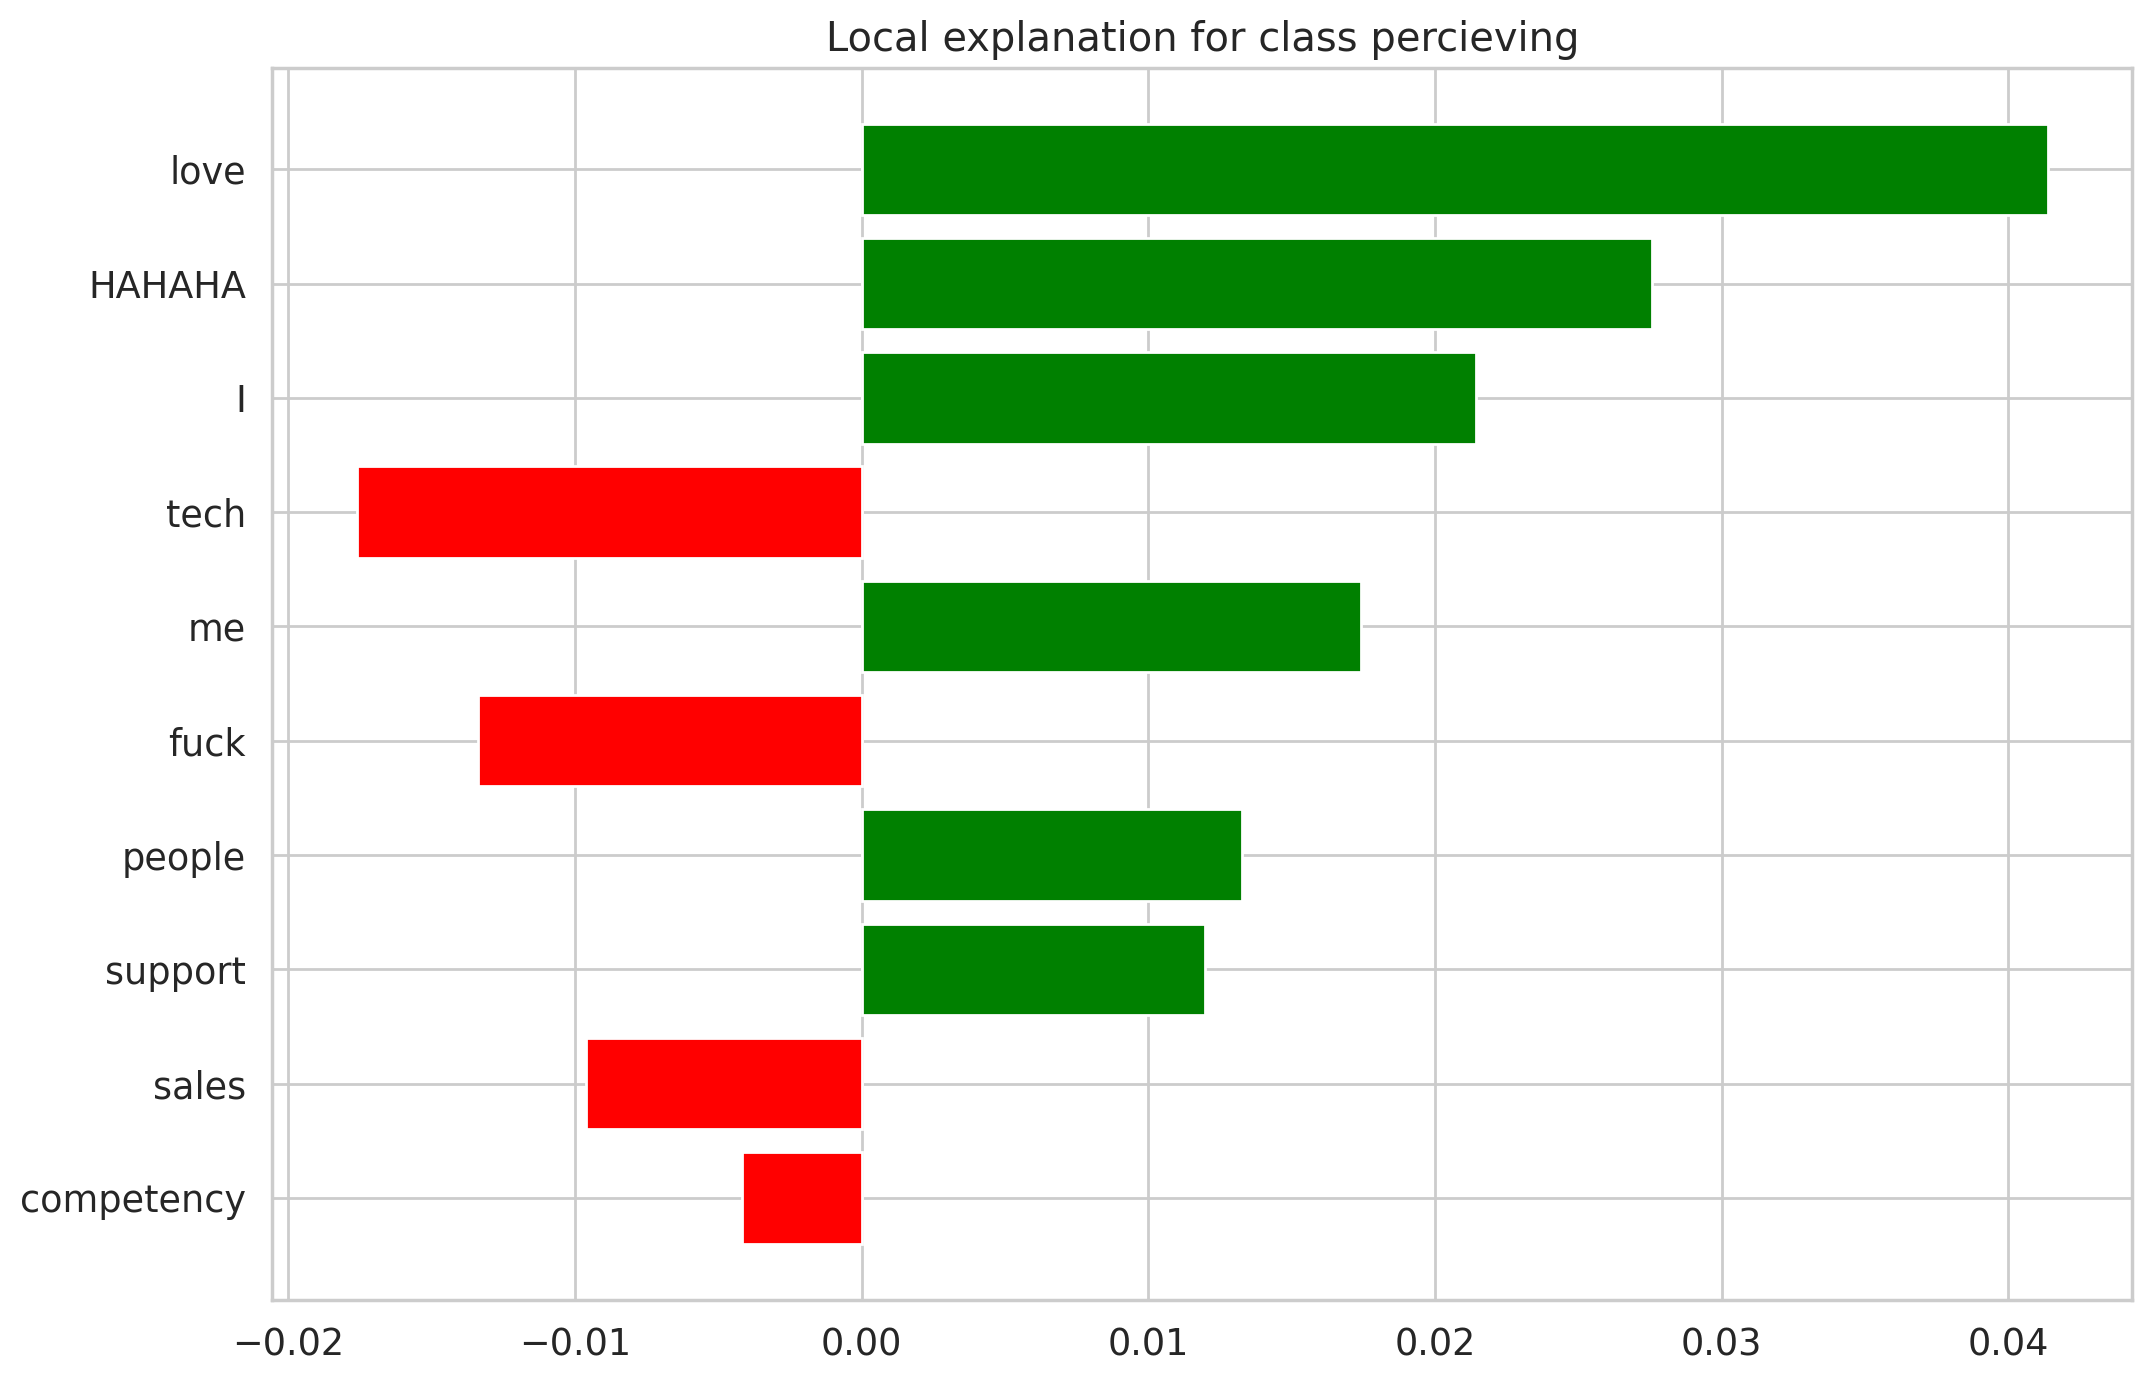

In [ ]:
words = explanation.as_list()
print(words)
%matplotlib inline
fig = explanation.as_pyplot_figure()

In [ ]:
predict_with_bert_linear(sample_text)

[[0.6623688 0.3376312]]


array([[0.6623688, 0.3376312]], dtype=float32)